In [1]:
import time
from mesa import Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa import Agent
import numpy as np
import random
import matplotlib.pyplot as plt

from collections import defaultdict
from heuristics.heuristique import evaluate
from algos.algo_rs import algoRS
from algos.algo_tabou import algoTabou
from algos.algo_genetique import algoOrga


from concurrent.futures import ThreadPoolExecutor


<h2>1-<u>Conception des Agents: </u></h2>

Objectif des Agents :

    Les agents  sont conçus pour appliquer respectivement les algorithmes algoRS  et algoTabou algoOrga afin de maximiser la "fitness" de la solution.
    Chaque agent teste des solutions dans l’espace de recherche en utilisant ses propres paramètres et observe si la fitness s'améliore.

    l'agent améliore ces paramètres chaque fois 

In [3]:
tabu=[]
rs=[]
orga=[]


class TabuAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.max_iterations = 100
        self.tabou_size = 10

    def step(self):
        new_solution = algoTabou(self.model.best_solution, self.model.metadata, max_iterations=self.max_iterations, tabou_size=self.tabou_size)
        new_fitness = evaluate(new_solution, self.model.metadata)

        tabu.append((new_solution,new_fitness))

        if  new_fitness > self.model.best_fitness:
            self.model.best_solution = new_solution
            self.model.best_fitness = new_fitness
        else:
            # Update parameters of Tabu algorithm
            self.max_iterations = min(500, self.max_iterations + 10)
            self.tabou_size = min(50, self.tabou_size + 1)
        
        return new_solution, new_fitness

class RSAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.T_initial = 100
        self.max_iter = 1000

    def step(self):
        new_solution = algoRS(self.model.best_solution, self.model.metadata, T_initial=self.T_initial, max_iter=self.max_iter)
        new_fitness = evaluate(new_solution, self.model.metadata)

        rs.append((new_solution,new_fitness))

        if  new_fitness > self.model.best_fitness:
            self.model.best_solution = new_solution
            self.model.best_fitness = new_fitness
        else:
            # Update RS parameters
            self.T_initial = min(500, self.T_initial + 20)
            self.max_iter = min(10000, self.max_iter + 200)
        
        return new_solution, new_fitness



#TODO : geneAgent


from random import choice


class OrgaAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.population_size = 50
        self.Pcross = 0.8
        self.Pmut = 0.1
        self.type_croisement = "2point"

        # Initialize population
        self.model = model
        self.metadata = model.metadata
        self.population = self.initialize_population(self.model.best_solution)
        self.current_best_solution = self.model.best_solution

    def initialize_population(self, base_solution):
        """Initialize a new population based on the given base solution."""
        population = []
        for i in range(10):
            if i % 2 == 0:
                population.append(algoTabou(base_solution, self.metadata))
            else:
                population.append(algoRS(base_solution, self.metadata))
        return population

    def step(self):

        if self.model.best_solution != self.current_best_solution:
            # Reinitialize population based on the new best solution
            self.population = self.initialize_population(self.model.best_solution)
            self.current_best_solution = self.model.best_solution
            print("Population reinitialized due to new best solution.")

        print(f"Population at start of step: {self.population}")
        new_solution = algoOrga(
           self.population,
            self.metadata,
            Pcross=self.Pcross,
            Pmut=self.Pmut,
            type_croisement=self.type_croisement,
            epochs=10000
        )
        
        new_fitness = evaluate(new_solution, self.model.metadata)

        orga.append((new_solution,new_fitness))
        

        if  new_fitness > self.model.best_fitness:
            self.current_best_solution=new_solution
            self.model.best_solution = new_solution
            self.model.best_fitness = new_fitness
        else:
            # Update Orga parameters
            self.population_size = min(200, self.population_size + 10)
            self.Pmut = max(0.01, self.Pmut - 0.005)
        
        return new_solution, new_fitness

       


<h2>2-<u>Conception de l'environnement: </u></h2>

Dans cet environnement, les agents partent d'une solution initiale. Après chaque exécution de leur algorithme, <strong>si l'un des agents trouve une solution améliorée</strong>, il met à jour la solution initiale. <strong>Les autres agents repartent alors de cette nouvelle solution </strong>jusqu'à ce qu'une autre meilleure solution soit trouvée, et ainsi de suite.


In [8]:
p1=[]
p2=[]
p3=[]
p4=[]
p5=[]
p6=[]

class Env(Model):
    def __init__(self, initial_solution, metadata, num_episodes=100):
        super().__init__()
        self.schedule = RandomActivation(self)
        self.initial_solution = initial_solution
        self.metadata = metadata
        self.best_solution = initial_solution
        self.best_fitness = evaluate(initial_solution, metadata)
        
        # Initialize agents
        self.rs_agent = RSAgent(1, self)
        self.tabu_agent = TabuAgent(2, self)
        self.orga_agent = OrgaAgent(3, self)
        
        # Data collection
        self.fitness_history = []
        self.rs_params_history = []
        self.tabu_params_history = []
        self.orga_params_history = []

    def step(self):
        best_agent_name = None
        current_best_fitness = self.best_fitness

        with ThreadPoolExecutor() as executor:
            futures = {
                executor.submit(agent.step): agent.__class__.__name__
                for agent in [self.rs_agent, self.tabu_agent, self.orga_agent]
            }

            for future in futures:
                agent_name = futures[future]
                start_time = time.time()
                try:
                    new_solution, new_fitness = future.result()
                    execution_time = time.time() - start_time
                    print(f"{agent_name} executed in {execution_time:.4f} seconds with fitness: {new_fitness}")

                    if new_fitness > self.best_fitness:
                        self.best_solution = new_solution
                        self.best_fitness = new_fitness
                        best_agent_name = agent_name
                except Exception as e:
                    print(f"Error in {agent_name}: {e}")

        if best_agent_name:
            print(f"==> {best_agent_name} provided the best solution with fitness {self.best_fitness}")

        # Update history for visualization
        self.fitness_history.append(self.best_fitness)
        self.rs_params_history.append((self.rs_agent.T_initial, self.rs_agent.max_iter))
        p3.append(self.rs_agent.max_iter)
        p4.append(self.rs_agent.T_initial)
        self.tabu_params_history.append((self.tabu_agent.max_iterations, self.tabu_agent.tabou_size))
        p1.append(self.tabu_agent.max_iterations)
        p2.append(self.tabu_agent.tabou_size)
        
        self.orga_params_history.append((self.orga_agent.population_size, self.orga_agent.Pmut))
        p5.append(self.orga_agent.population_size)
        p6.append(self.orga_agent.Pmut)
    
    def run_model(self, num_steps=100):
        for i in range(num_steps):
            print(f"\n--- Step {i+1}/{num_steps} ---")
            self.step()

            print(f"solution:{self.best_solution}")
            print(f"Best Fitness so far: {self.best_fitness}")
        self.plot_results()

    def plot_results(self):
        plt.figure(figsize=(12, 6))

        # Plot fitness history
        plt.subplot(2, 1, 1)
        plt.plot(self.fitness_history, label="Best Fitness", color="blue")
        plt.xlabel("Steps")
        plt.ylabel("Fitness")
        plt.legend()

        # Plot parameters
        plt.subplot(2, 1, 2)
        T_initial_vals = [p[0] for p in self.rs_params_history]
        max_iter_vals = [p[1] for p in self.rs_params_history]
        max_iterations_vals = [p[0] for p in self.tabu_params_history]
        tabou_size_vals = [p[1] for p in self.tabu_params_history]

        plt.plot(T_initial_vals, label="T_initial (RS)", color="orange")
        plt.plot(max_iter_vals, label="max_iter (RS)", color="purple")
        plt.plot(max_iterations_vals, label="max_iterations (Tabu)", color="green")
        plt.plot(tabou_size_vals, label="tabou_size (Tabu)", color="red")

        plt.subplot(3, 1, 3)
        population_size_vals = [p[0] for p in self.orga_params_history]
        Pmut_vals = [p[1] for p in self.orga_params_history]

        plt.plot(population_size_vals, label="population_size (Orga)", color="brown")
        plt.plot(Pmut_vals, label="Pmut (Orga)", color="pink")
        
        plt.xlabel("Steps")
        plt.ylabel("Parameter Values")
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.show()

<h2>3-<u>Test: </u></h2>

In [9]:
from excel_io.excel import Voeux , ExcelSolution
from models import MedecinData, Metadata

excel_solution = ExcelSolution(r"./input_garde_1.xlsx")
solution = excel_solution.read_solution()

voeux = Voeux(r"./input_garde_1.xlsx", r"./input_astreinte_1.xlsx")
excel_solution = ExcelSolution(r"./input_garde_1.xlsx")
solution = excel_solution.read_solution()

medecins_garde = {solution[i][0] for i in range(len(solution))}
medecins_astreinte = {solution[i][1] for i in range(len(solution))}

specialisation = {"JMR", "MC", "PDS", "CP", "AVL", "FL", "JC", "SD", "GD", "MDT"}
Gmax = 100 ## todo : mettre une valeur cohérante
voeux_nbr_gardes = {medecin: 0 for medecin in medecins_garde}

medecin_data = MedecinData(medecins_garde, medecins_astreinte, specialisation, Gmax, voeux_nbr_gardes)
metadata = Metadata(medecin_data, voeux.data, {}, {})


--- Step 1/100 ---
RSAgent executed in 0.0000 seconds with fitness: 4.7681818181818185
TabuAgent executed in 0.0348 seconds with fitness: 6.0
Population reinitialized due to new best solution.
Population at start of step: [[('DB', 'JMR'), ('MC', 'PDS'), ('CP', 'JMR'), ('JMR', 'CP'), ('AVL', 'JMR'), ('SD', 'PDS'), ('MC', 'GD'), ('AVL', 'MC'), ('FL', 'MDT'), ('JC', 'JMR'), ('DB', 'MDT'), ('JC', 'MC'), ('CP', 'AVL'), ('PDS', 'MDT'), ('DB', 'JMR'), ('JG', 'MDT'), ('PDS', 'JMR'), ('AVL', 'MDT'), ('JC', 'JMR'), ('MDE', 'MC'), ('JC', 'FL'), ('MDX', 'GD'), ('GD', 'MC'), ('MDT', 'JMR'), ('DB', 'CP'), ('MDX', 'MDT'), ('MDE', 'JMR'), ('JC', 'MDT'), ('AVL', 'CP'), ('GD', 'MDT'), ('MDT', 'JMR'), ('SD', 'FL'), ('MDS', 'CP'), ('MDE', 'MDT'), ('CP', 'MC'), ('MDT', 'GD'), ('AVL', 'GD'), ('PDS', 'JMR'), ('JMR', 'PDS'), ('DB', 'CP'), ('SD', 'GD'), ('GD', 'MC'), ('MC', 'CP'), ('PDS', 'CP'), ('MC', 'JMR'), ('SD', 'CP'), ('JG', 'PDS'), ('MC', 'PDS'), ('GD', 'PDS'), ('FL', 'JMR'), ('SD', 'GD'), ('FL', 'JMR'

C:\Users\ifree\AppData\Local\Temp\ipykernel_18856\3126185664.py:100: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 3)
C:\Users\ifree\AppData\Local\Temp\ipykernel_18856\3126185664.py:110: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


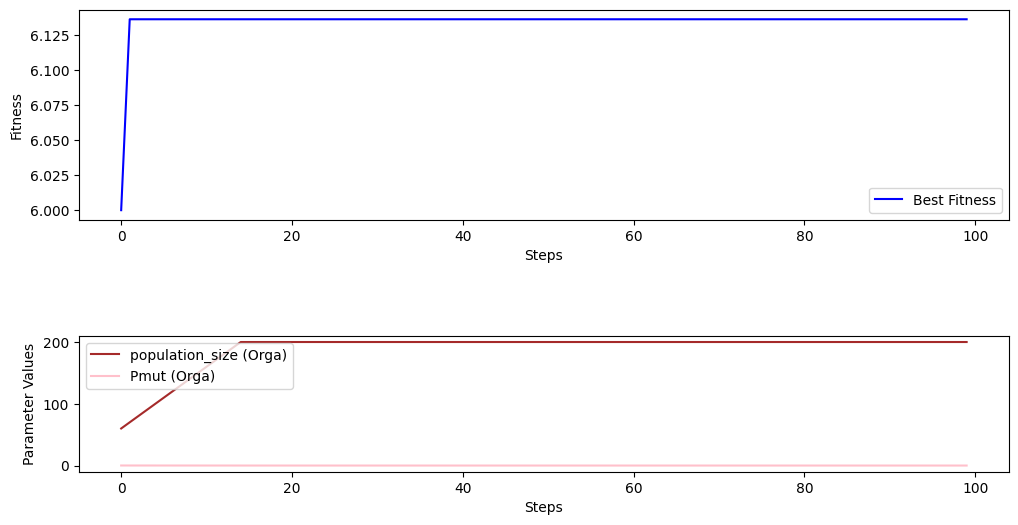

In [10]:
model = Env(solution, metadata, num_episodes=100)
model.run_model(num_steps=100)

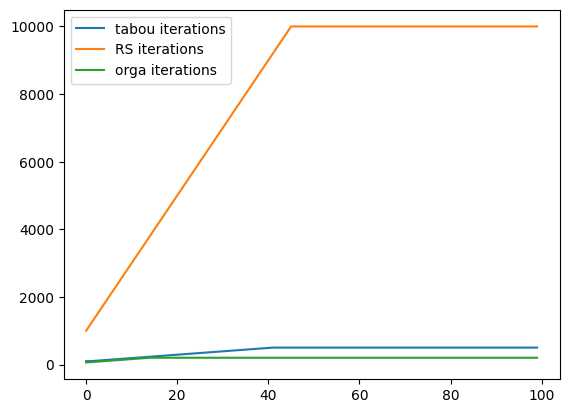

In [21]:
plt.plot(range(100),p1,label='tabou iterations')
plt.plot(range(100),p3,label='RS iterations')
plt.plot(range(100),p5,label='orga iterations')
plt.legend()
plt.show()

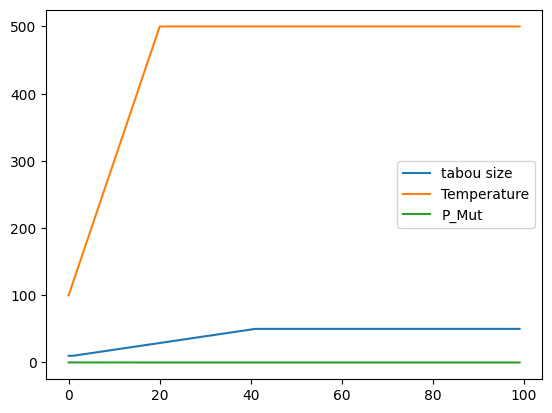

In [22]:
plt.plot(range(100),p2,label='tabou size ')
plt.plot(range(100),p4,label="Temperature")
plt.plot(range(100),p6,label='P_Mut')
plt.legend()
plt.show()

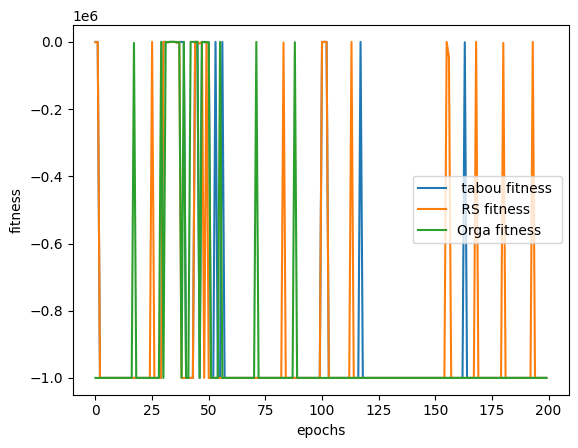

In [29]:
plt.plot(range(200),[tabu[i][1] for i in range(len(tabu))],label=" tabou fitness ")
plt.plot(range(200),[rs[i][1] for i in range(len(tabu))],label=' RS fitness ')
plt.plot(range(200),[orga[i][1] for i in range(len(tabu))], label='Orga fitness')
plt.ylabel("fitness")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [28]:
tabu[1]

([('AVL', 'PDS'),
  ('MDT', 'PDS'),
  ('CP', 'JMR'),
  ('MC', 'CP'),
  ('MDS', 'FL'),
  ('JC', 'FL'),
  ('SD', 'GD'),
  ('MDE', 'MDT'),
  ('PDS', 'DB'),
  ('MDS', 'JMR'),
  ('MDT', 'JMR'),
  ('AVL', 'GD'),
  ('MDT', 'GD'),
  ('MDT', 'JMR'),
  ('SD', 'JMR'),
  ('GD', 'MDT'),
  ('JMR', 'JMR'),
  ('JG', 'MC'),
  ('DB', 'JMR'),
  ('PDS', 'PDS'),
  ('MDE', 'FL'),
  ('DB', 'GD'),
  ('DB', 'AVL'),
  ('CP', 'JMR'),
  ('MDT', 'MC'),
  ('MC', 'CP'),
  ('MC', 'DB'),
  ('JMR', 'MDT'),
  ('JC', 'JMR'),
  ('CP', 'DB'),
  ('DB', 'JMR'),
  ('CP', 'PDS'),
  ('CP', 'FL'),
  ('GD', 'MC'),
  ('FL', 'MC'),
  ('FL', 'JMR'),
  ('MDX', 'GD'),
  ('GD', 'JMR'),
  ('PDS', 'PDS'),
  ('MDE', 'CP'),
  ('MDX', 'GD'),
  ('AVL', 'MDE'),
  ('JG', 'JMR'),
  ('AVL', 'MC'),
  ('DB', 'JMR'),
  ('JMR', 'CP'),
  ('SD', 'GD'),
  ('PDS', 'GD'),
  ('MC', 'GD'),
  ('SD', 'JMR'),
  ('JG', 'GD'),
  ('AVL', 'JMR'),
  ('JC', 'PDS'),
  ('GD', 'PDS'),
  ('FL', 'GD')],
 6.045454545454546)

In [8]:
[tabu[i][1] for i in range(len(tabu))]

[5.963636363636364,
 6.045454545454546,
 6.045454545454546,
 -1000000,
 -1000000,
 -994.0454545454545,
 6.045454545454546,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 6.136363636363637,
 6.136363636363637,
 6.136363636363637,
 -1000000,
 6.136363636363637,
 -1000000,
 -1000000,
 -1000000,
 6.136363636363637,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -10000

<h2>4-<u>une autre approche: </u></h2>

# Optimisation des Paramètres avec Q-learning pour les Agents Tabou et Recuit Simulé

Dans la simulation précédente, le choix des paramètres par les algorithmes se faisait de manière moins intelligente. Dans cette approche, les agents vont apprendre à choisir les paramètres optimaux en utilisant une approche d'apprentissage par renforcement (**Q-learning**) et un système de récompenses.

## Fonctionnement de l'Optimisation par Q-learning

### 1. Choix des Actions

L'agent modifie un paramètre spécifique (par exemple, la température initiale pour le recuit simulé ou la taille de la liste taboue pour la recherche taboue) pour explorer différentes configurations.

### 2. Calcul des Récompenses

La récompense est calculée comme la différence entre la fitness obtenue avec la nouvelle solution et la fitness de la meilleure solution actuelle. Ce système de récompenses incite les agents à chercher des solutions améliorant la fitness.

### 3. Application de l'Algorithme de Q-learning

L'algorithme de Q-learning utilise une Q-table contenant les actions et leurs récompenses. La Q-table est mise à jour selon la formule suivante :


<strong>Q(s,a)←Q(s,a)+α×(reward+γ×max(Q(s′,a′))−Q(s,a))</strong>
<style> strong{
    color:red;
}</style>

Cette mise à jour permet aux agents d'apprendre les meilleures actions pour chaque configuration de paramètres.

Les agents utilisent une stratégie **epsilon-greedy** pour choisir leurs actions : ils explorent des actions aléatoires avec une probabilité \(\epsilon\) (epsilon), et choisissent sinon les meilleures actions enregistrées dans la Q-table.



In [35]:

qtabu=[]
qrs=[]
qorga=[]

q_table_tabu_history = []
q_table_rs_history = []
q_table_orga_history = []


class QAgentTabou(Agent):
    def __init__(self, unique_id, model, alpha=0.1, gamma=0.9, epsilon=0.2):
        super().__init__(unique_id, model)
        self.alpha = alpha  # Taux d'apprentissage
        self.gamma = gamma  # Facteur de discount
        self.epsilon = epsilon  # Taux d'exploration
        self.q_table = defaultdict(lambda: np.zeros(2))  # Q-table pour état-action
        self.best_solution = model.initial_solution
        self.best_fitness = model.best_fitness
        self.parameters = [100, 10]  # Paramètres initiaux : [max_iterations, tabou_size]

    def choose_action(self, state):
        # Politique epsilon-greedy
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1]) 
        else:
            return np.argmax(self.q_table[state])  

    def step(self):
        # État actuel basé sur les paramètres
        state = tuple(self.parameters)

        # Choisir une action avec Q-learning (0 = ajustement max_iterations, 1 = ajustement tabou_size)
        action = self.choose_action(state)

        # Ajuster les paramètres en fonction de l'action
        if action == 0:
            self.parameters[0] += np.random.randint(-10, 10)  # Ajustement de max_iterations
        else:
            self.parameters[1] += np.random.randint(-2, 2)    # Ajustement de tabou_size

        new_solution = algoTabou(self.best_solution, self.model.metadata, max_iterations=self.parameters[0], tabou_size=self.parameters[1])
        new_fitness = evaluate(new_solution, self.model.metadata)

        qtabu.append((new_solution,new_fitness))

        # Calcul de la récompense
        reward = new_fitness - self.best_fitness

        
        if new_fitness > self.best_fitness:
            self.best_solution = new_solution
            self.best_fitness = new_fitness
            if new_fitness > self.model.best_fitness:
                self.model.best_solution = new_solution
                self.model.best_fitness = new_fitness

        # Mise à jour de la Q-table
        next_state = tuple(self.parameters)
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state][action] = new_value

        q_table_tabu_history.append(dict(self.q_table))


class QAgentRS(Agent):
    def __init__(self, unique_id, model, alpha=0.1, gamma=0.9, epsilon=0.2):
        super().__init__(unique_id, model)
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = epsilon  
        self.q_table = defaultdict(lambda: np.zeros(2))
        self.best_solution = model.initial_solution
        self.best_fitness = model.best_fitness
        self.parameters = [100, 1000] 

    def choose_action(self, state):
      
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1])  
        else:
            return np.argmax(self.q_table[state])  

    def step(self):
        
        state = tuple(self.parameters)

        
        action = self.choose_action(state)

        
        if action == 0:
            self.parameters[0] += np.random.randint(-10, 10)  
        else:
            self.parameters[1] += np.random.randint(-100, 100) 

        
        new_solution = algoRS(self.best_solution, self.model.metadata, T_initial=self.parameters[0], max_iter=self.parameters[1])
        new_fitness = evaluate(new_solution, self.model.metadata)

        qrs.append((new_solution,new_fitness))

        
        reward = new_fitness - self.best_fitness

      
        if new_fitness > self.best_fitness:
            self.best_solution = new_solution
            self.best_fitness = new_fitness
            if new_fitness > self.model.best_fitness:
                self.model.best_solution = new_solution
                self.model.best_fitness = new_fitness

       
        next_state = tuple(self.parameters)
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state][action] = new_value

        q_table_rs_history.append(dict(self.q_table))




class QAgentOrga(Agent):
    def __init__(self, unique_id, model, alpha=0.1, gamma=0.9, epsilon=0.2):
        super().__init__(unique_id, model)
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = defaultdict(lambda: np.zeros(3))  # Q-table for state-action pairs

        # Initial parameters
        self.population_size = 50
        self.Pcross = 0.8
        self.Pmut = 0.1
        self.type_croisement = "2point"
        self.epochs = 10000

        # Track the best solution and fitness for this agent
        self.best_solution = model.initial_solution
        self.best_fitness = model.best_fitness


        self.metadata=metadata
        self.population=self.initialize_population(self.model.best_solution)

    def initialize_population(self, base_solution):
        """Initialize a new population based on the given base solution."""
        population = []
        for i in range(10):
            if i % 2 == 0:
                population.append(algoTabou(base_solution, self.metadata))
            else:
                population.append(algoRS(base_solution, self.metadata))
        return population
    def choose_action(self, state):
        # Epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            return np.random.choice([0, 1, 2])  # Three actions for three parameters
        else:
            return np.argmax(self.q_table[state])

    def step(self):
        # Current state based on parameters
        state = (self.population_size, self.Pcross, self.Pmut)

        # Choose action: 0 to adjust population_size, 1 to adjust Pcross, 2 to adjust Pmut
        action = self.choose_action(state)

        # Modify parameters based on action
        if action == 0:
            self.population_size += np.random.randint(-10, 10)
            self.population_size = max(10, min(self.population_size, 200))  # Constrain to sensible values
        elif action == 1:
            self.Pcross += np.random.uniform(-0.05, 0.05)
            self.Pcross = max(0.5, min(self.Pcross, 1.0))  # Constrain between 0.5 and 1.0
        elif action == 2:
            self.Pmut += np.random.uniform(-0.02, 0.02)
            self.Pmut = max(0.01, min(self.Pmut, 0.3))  # Constrain between 0.01 and 0.3

        # Run the genetic algorithm with updated parameters
        new_solution = algoOrga(
            self.population,
            self.metadata,
            Pcross=self.Pcross,
            Pmut=self.Pmut,
            type_croisement=self.type_croisement,
            epochs=self.epochs
        )
        
        new_fitness = evaluate(new_solution, self.metadata)

        qorga.append((new_solution,new_fitness))

        # Store results for analysis
        qorga.append((new_solution, new_fitness))

        # Calculate reward
        reward = new_fitness - self.best_fitness

        # Update best solution if this is an improvement
        if new_fitness > self.best_fitness:
            self.best_solution = new_solution
            self.best_fitness = new_fitness
            if new_fitness > self.model.best_fitness:
                self.model.best_solution = new_solution
                self.model.best_fitness = new_fitness

        # Update Q-table using Q-learning formula
        next_state = (self.population_size, self.Pcross, self.Pmut)
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state][action] = new_value


        q_table_orga_history.append(dict(self.q_table))

        return new_solution, new_fitness

In [37]:
class QLearningEnv(Model):
    def __init__(self, initial_solution, metadata, num_episodes=100):
        super().__init__()
        self.schedule = RandomActivation(self)
        self.initial_solution = initial_solution
        self.metadata = metadata
        self.best_solution = initial_solution
        self.best_fitness = evaluate(initial_solution, metadata)
        self.num_episodes = num_episodes

        
        self.fitness_history = []

        
        self.q_agents = []
        self.q_agents.append(QAgentTabou(1, self))  # Agent pour la recherche taboue
        self.q_agents.append(QAgentRS(2, self))     # Agent pour le recuit simulé
        self.q_agents.append(QAgentOrga(3, self))     # Agent pour le recuit simulé
        for agent in self.q_agents:
            self.schedule.add(agent)

    def step(self):
        # Exécuter tous les agents 
        self.schedule.step()
        
       
        self.fitness_history.append(self.best_fitness)

    def run_model(self):
        for episode in range(self.num_episodes):
            self.step()
            print(f"Episode {episode+1}/{self.num_episodes}, Best Fitness: {self.best_fitness}")

        # Afficher les résultats finaux
        self.plot_results()

    def plot_results(self):
        
        plt.figure(figsize=(12, 6))
        plt.plot(self.fitness_history, label="Best Fitness", color="blue")
        plt.xlabel("Episodes")
        plt.ylabel("Fitness")
        plt.legend()
        plt.show()

Episode 1/300, Best Fitness: -494.1818181818182
Episode 2/300, Best Fitness: 6.0
Episode 3/300, Best Fitness: 6.0
Episode 4/300, Best Fitness: 6.090909090909091
Episode 5/300, Best Fitness: 6.136363636363637
Episode 6/300, Best Fitness: 6.136363636363637
Episode 7/300, Best Fitness: 6.136363636363637
Episode 8/300, Best Fitness: 6.136363636363637
Episode 9/300, Best Fitness: 6.136363636363637
Episode 10/300, Best Fitness: 6.136363636363637
Episode 11/300, Best Fitness: 6.136363636363637
Episode 12/300, Best Fitness: 6.136363636363637
Episode 13/300, Best Fitness: 6.136363636363637
Episode 14/300, Best Fitness: 6.136363636363637
Episode 15/300, Best Fitness: 6.136363636363637
Episode 16/300, Best Fitness: 6.136363636363637
Episode 17/300, Best Fitness: 6.136363636363637
Episode 18/300, Best Fitness: 6.136363636363637
Episode 19/300, Best Fitness: 6.136363636363637
Episode 20/300, Best Fitness: 6.136363636363637
Episode 21/300, Best Fitness: 6.136363636363637
Episode 22/300, Best Fitness

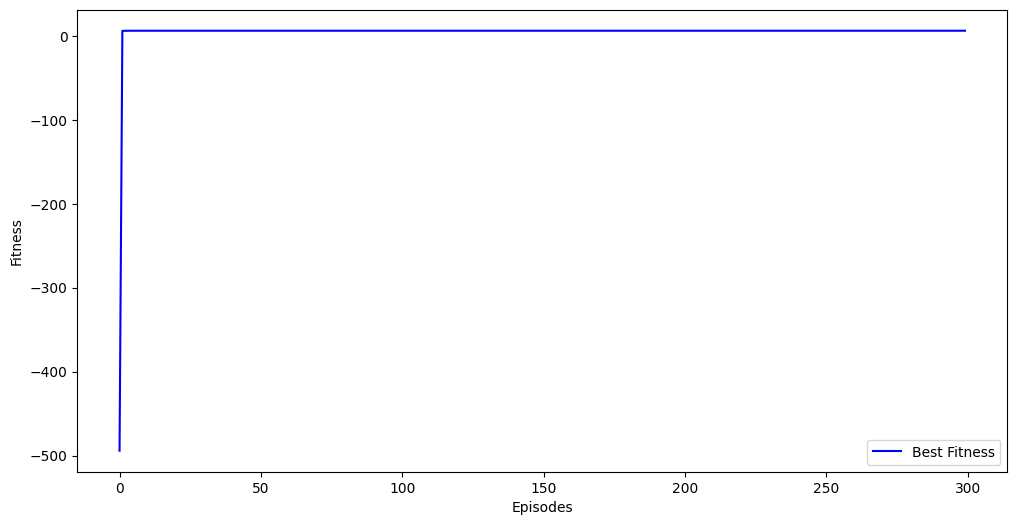

In [38]:
model1 = QLearningEnv(solution, metadata, num_episodes=300)
model1.run_model()

<h1>comparaison</h1>

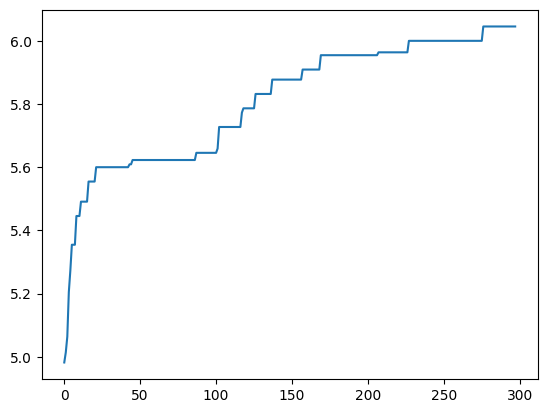

In [ ]:
# la fitnes de  l'agent QRS pour les 100 iteration 
plt.plot(range(300-2),[qrs[i][1] for i in range(2,len(qtabu))])
plt.show()

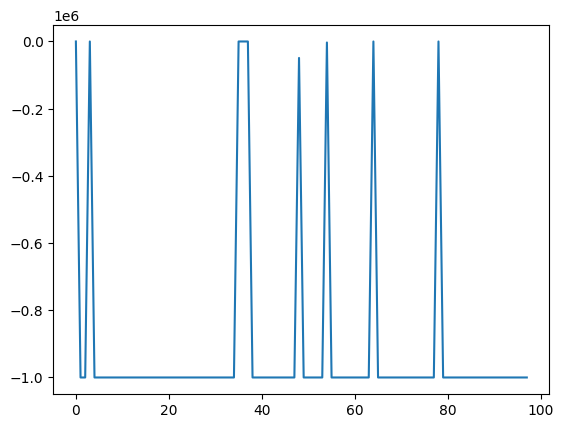

In [ ]:
#la fitness de l'agent RS 
plt.plot(range(100-2),[rs[i][1] for i in range(2,len(tabu))])
plt.show()

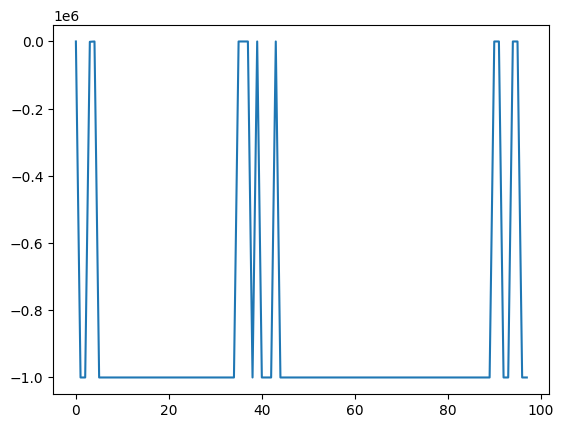

In [ ]:
#fitnes de  l'agent Tabou 
plt.plot(range(100-2),[tabu[i][1] for i in range(2,len(tabu))])
plt.show()

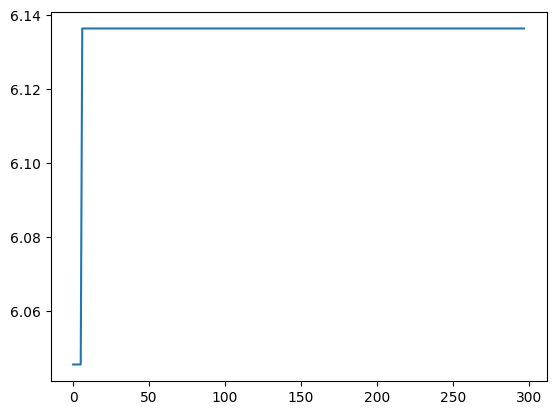

In [31]:
#fitnes de  l'agent QTabou 
plt.plot(range(300-2),[qtabu[i][1] for i in range(2,len(qtabu))])
plt.show()

In [ ]:
plt.plot(range(300-2),[qorga[i][1] for i in range(2,len(qtabu))])
plt.show()

In [ ]:
q_table_tabu_history


# dans chaque agent on fait un Q-tableau ;
# la structure de ce tableau est  ['state1":Q_valeur1  ; 'state2':Q_valeur2;...]

'''
    Example values:

    (100, 10): array([1200.40272727, 0.]): In the state (100, 10), the Q-value for max_iterations adjustment (Action 0) is 1200.40272727, while the Q-value for tabou_size adjustment (Action 1) is 0.


'''

#l algorithme favorise les parametres qui influence + la fitness  



[{(100, 10): array([1200.40272727,    0.        ]),
  (101, 10): array([50.01818182,  0.        ])},
 {(100, 10): array([1200.40272727,    0.        ]),
  (101, 10): array([50.01818182,  0.        ]),
  (92, 10): array([0., 0.])},
 {(100, 10): array([1200.40272727,    0.        ]),
  (101, 10): array([50.01818182,  0.        ]),
  (92, 10): array([0., 0.]),
  (83, 10): array([0.00909091, 0.        ])},
 {(100, 10): array([1200.40272727,    0.        ]),
  (101, 10): array([50.01818182,  0.        ]),
  (92, 10): array([0., 0.]),
  (83, 10): array([0.00909091, 0.        ]),
  (90, 10): array([0.00454545, 0.        ])},
 {(100, 10): array([1200.40272727,    0.        ]),
  (101, 10): array([50.01818182,  0.        ]),
  (92, 10): array([0., 0.]),
  (83, 10): array([0.00909091, 0.        ]),
  (90, 10): array([0.00454545, 0.        ]),
  (88, 10): array([0., 0.])},
 {(100, 10): array([1200.40272727,    0.        ]),
  (101, 10): array([50.01818182,  0.        ]),
  (92, 10): array([0., 0.

In [31]:
from numpy import array

In [ ]:
q=[{(100, 10): array([1200.40272727,    0.        ]),
  (101, 10): array([50.01818182,  0.        ])},
 {(100, 10): array([1200.40272727,    0.        ]),
  (101, 10): array([50.01818182,  0.        ]),
  (92, 10): array([0., 0.])}]

In [35]:
import pandas as pd
import numpy as np

# Original Q-table data
q = [
    {(100, 10): np.array([1200.40272727, 0.0]),
     (101, 10): np.array([50.01818182, 0.0])},
    {(100, 10): np.array([1200.40272727, 0.0]),
     (101, 10): np.array([50.01818182, 0.0]),
     (92, 10): np.array([0.0, 0.0])}
]

# Collect all unique states and actions
all_states = set()
all_actions = set()

for episode in q:
    for (state, action), values in episode.items():
        all_states.add(state)
        all_actions.add(action)

all_states = sorted(all_states)
all_actions = sorted(all_actions)

# Create an empty DataFrame to store Q-values in grid format
grid = pd.DataFrame(index=all_states, columns=all_actions)
grid = grid.applymap(lambda x: [0.0, 0.0])  # Initialize with zeros

# Populate the grid with Q-values
for episode in q:
    for (state, action), values in episode.items():
        grid.loc[state, action] = values

# Display the grid-like Q-table
print(grid)


                       10
92             [0.0, 0.0]
100  [1200.40272727, 0.0]
101    [50.01818182, 0.0]


<strong>L'algorithme de Q-learning pour le RL <u>converge lentement</u>, nécessitant donc plus de temps et d'épisodes pour fournir des résultats optimaux. Cela ne signifie pas pour autant qu'il est moins efficace.</strong>

<style>
    strong{color:red;}
</style>